### Import modules and verify they work? 

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# general eWC
import ewatercycle
import ewatercycle.models

In [3]:
# pip install ewatercycle-HBV==1.1.0

In [4]:
# pip install HBV==1.1.1

In [5]:
# pip install https://github.com/Daafip/HBV-bmi/tree/dev

In [6]:
# for local mode
from typing import Type
from ewatercycle.base.model import LocalModel
from ewatercycle_HBV.model import HBVMethods # Use custom forcing instead
from HBV import HBV as HBV_bmi
from bmipy import Bmi

class LocalModelHBV(LocalModel, HBVMethods):
    """The HBV eWaterCycle model, with the local BMI."""
    bmi_class: Type[Bmi] = HBV_bmi

#### set up paths

In [10]:
path = Path.cwd()
forcing_path = path / "Forcing"
forcing_path

PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/Forcing')

#### add parameter info

In [11]:
## Array of initial storage terms - we keep these constant for now 
##              Si,  Su, Sf, Ss
s_0 = np.array([0,  100,  0,  5])

## Array of parameters min/max bounds as a reference
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks"]

# set initial as mean of max,min
par_0 = (p_min_initial + p_max_initial)/2

In [12]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2000-08-31T00:00:00Z"

In [13]:
from ewatercycle_HBV.forcing import HBVForcing

In [14]:
test_forcing = HBVForcing(start_time = experiment_start_date,
                          end_time = experiment_end_date,
                          directory = forcing_path,
                          forcing_file = "test_forcing.txt",
                          )

In [15]:
ds = test_forcing.to_xarray()

#### Can also run locally when developing - v0.1.1. here
```py
from ewatercycle.container import ContainerImage
LeakyBucket(forcing=forcing, bmi_image=ContainerImage("local_image:latest"))
```

In [16]:
from ewatercycle.container import ContainerImage
local_model = LocalModelHBV(forcing=test_forcing)

need to  add a local container to run

In [17]:
config_file, _ = local_model.setup(
            parameters=','.join([str(p) for p in par_0]),
            initial_storage=','.join([str(s) for s in s_0]),
           )

In [18]:
local_model.initialize(config_file)

In [19]:
Q_m = []
time = []
while local_model.time < local_model.end_time:
    local_model.update()
    Q_m.append(local_model.get_value("Q_m"))
    time.append(local_model.time_as_datetime.date())

local_model.finalize()

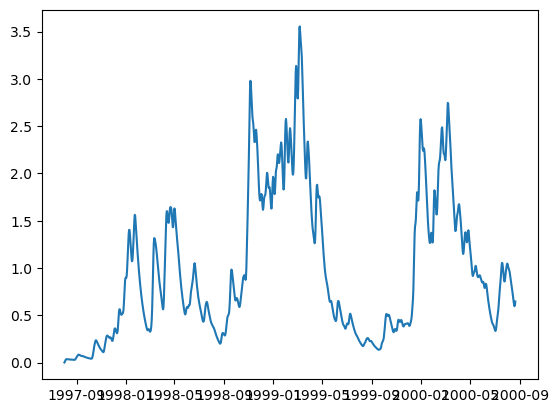

In [20]:
plt.plot(time[:-10], Q_m[:-10])

# testing with setting/getting values

In [21]:
local_model = LocalModelHBV(forcing=test_forcing)
config_file, _ = local_model.setup(
            parameters=','.join([str(p) for p in par_0]),
            initial_storage=','.join([str(s) for s in s_0]),
           )
local_model.initialize(config_file)

In [22]:
local_model.update()

In [23]:
local_model.get_value("Q_m")

array([0.00200467])

In [24]:
local_model.update()

In [25]:
local_model.get_value("Q_m")

array([0.00802432])

In [26]:
local_model.get_value("Tlag")[0]

6.0

In [27]:
for i in range(int(local_model.get_value("Tlag")[0])):
    print(i)

0
1
2
3
4
5


In [28]:
old_memory_vector = np.array([local_model.get_value(f"memory_vector{i}") for i in range(int(local_model.get_value("Tlag")[0]))]).flatten()
old_memory_vector

array([0.01605427, 0.02007488, 0.01606553, 0.00803558, 0.0020103 ,
       0.        ])

In [29]:
old_T_lag = 5

In [30]:
# local_model.set_value("Tlag",np.array([10]))

In [31]:
local_model.get_value("memory_vector1")

array([0.02007488])

In [32]:
new_T_lag = 6

In [33]:
# np.zeros(new_T_lag)+ old_memory_vector 

In [34]:
local_model.update()

In [35]:
old_memory_vector = np.array([local_model.get_value(f"memory_vector{i}") for i in range(int(local_model.get_value("Tlag")[0]))]).flatten()
old_memory_vector

array([0.02641495, 0.02663233, 0.01860238, 0.00835038, 0.00211336,
       0.        ])

In [36]:
new_memory_vector = np.zeros(new_T_lag)
new_memory_vector

array([0., 0., 0., 0., 0., 0.])

In [39]:
# new_memory_vector[:old_T_lag] = old_memory_vector

In [40]:
new_memory_vector

array([0., 0., 0., 0., 0., 0.])

In [41]:
local_model.update()

In [42]:
old_memory_vector = np.array([local_model.get_value(f"memory_vector{i}") for i in range(int(local_model.get_value("Tlag")[0]))]).flatten()
old_memory_vector

array([0.03512946, 0.02896779, 0.01857412, 0.0082138 , 0.00204516,
       0.        ])

In [43]:
new_T_lag = 3

In [44]:
new_memory_vector = np.zeros(new_T_lag)
new_memory_vector

array([0., 0., 0.])

In [45]:
if old_T_lag < new_T_lag:
    new_memory_vector[:old_T_lag] = old_memory_vector
elif old_T_lag > new_T_lag:
    new_memory_vector = old_memory_vector[:new_T_lag]
    new_memory_vector[-1] += sum(old_memory_vector[new_T_lag:])
    

In [46]:
new_memory_vector

array([0.03512946, 0.02896779, 0.02883309])

In [47]:
local_model.update()

In [48]:
old_memory_vector = np.array([local_model.get_value(f"memory_vector{i}") for i in range(int(local_model.get_value("Tlag")[0]))]).flatten()
old_memory_vector

array([0.03500886, 0.02864257, 0.01828225, 0.00808623, 0.00201369,
       0.        ])

In [49]:
local_model.set_value("Tlag",np.array([4]))

In [50]:
old_memory_vector = np.array([local_model.get_value(f"memory_vector{i}") for i in range(int(local_model.get_value("Tlag")[0]))]).flatten()
old_memory_vector

array([0.03500886, 0.02864257, 0.01828225, 0.01009992])

In [51]:
local_model.set_value("Tlag",np.array([5]))

In [52]:
old_memory_vector = np.array([local_model.get_value(f"memory_vector{i}") for i in range(int(local_model.get_value("Tlag")[0]))]).flatten()
old_memory_vector

array([0.03500886, 0.02864257, 0.01828225, 0.01009992, 0.        ])

In [49]:
local_model.finalize()

In [54]:
local_model.set_value("Tlag",np.array([0]))

In [55]:
old_memory_vector = np.array([local_model.get_value(f"memory_vector{i}") for i in range(int(local_model.get_value("Tlag")[0]))]).flatten()
old_memory_vector

array([0.09203359])